In [1]:
import pickle
import numpy as np

In [2]:
with open('train_qa.txt','rb') as f:
    train_data  = pickle.load(f)
with open('test_qa.txt','rb') as f:
    test_data  = pickle.load(f)

In [3]:
vocab = set()
all_data = test_data + train_data
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
    vocab.add('no')
    vocab.add('yes')

In [4]:
vocab_len = len(vocab) + 1
max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])
vocab_size = len(vocab) + 1

In [5]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [6]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [7]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    X = []
    Xq = []
    Y = []
    for story, query, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in query]
        y = np.zeros(len(word_index) + 1)
        y[word_index[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [8]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [9]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [10]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)
answer = concatenate([response, question_encoded])
answer = LSTM(32)(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, 64)     2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

In [12]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=120,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/120
313/313 [==============================] - 3s 11ms/step - loss: 0.7042 - accuracy: 0.5075 - val_loss: 0.6938 - val_accuracy: 0.4970
Epoch 2/120
313/313 [==============================] - 3s 10ms/step - loss: 0.6959 - accuracy: 0.4980 - val_loss: 0.6938 - val_accuracy: 0.5030
Epoch 3/120
313/313 [==============================] - 3s 10ms/step - loss: 0.6955 - accuracy: 0.4949 - val_loss: 0.6954 - val_accuracy: 0.4970
Epoch 4/120
313/313 [==============================] - 4s 11ms/step - loss: 0.6953 - accuracy: 0.4933 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 5/120
313/313 [==============================] - 4s 12ms/step - loss: 0.6943 - accuracy: 0.5008 - val_loss: 0.6943 - val_accuracy: 0.4970
Epoch 6/120
313/313 [==============================] - 3s 9ms/step - loss: 0.6953 - accuracy: 0.4911 - val_loss: 0.6937 - val_accuracy: 0.4970
Epoch 7/120
313/313 [==============================] - 3s 9ms/step - loss: 0.6945 - accuracy: 0.4921 - val_loss: 0.6938 - val_accuracy: 0

In [14]:
model.save('chatbot.h5')

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


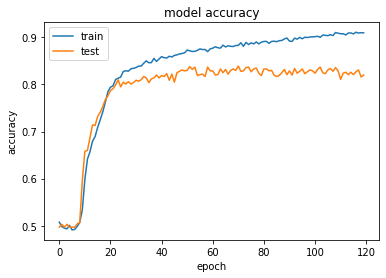

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()